In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import segmentation

from google.colab.patches import cv2_imshow

In [4]:
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

confThreshold = 0.0
nmsThreshold = 0.4

def postprocess(frameHeight, frameWidth, outs):
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                boxes.append([left, top, width, height])
    return boxes

In [5]:
inpWidth, inpHeight = 608, 608

def fore_ground_segmentation(filename):
    n = 1000
    frame = cv2.imread(filename)
    original_frame = frame.copy()
    blob = cv2.dnn.blobFromImage(frame, 1 / 255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)
    net.setInput(blob)
    outs = net.forward(getOutputsNames(net))
    framewidth, frameheight = frame.shape[1], frame.shape[0]
    boxes = postprocess(frameheight, framewidth, outs)
    if len(boxes):
        [left, top, width, height] = boxes[0]
    else:
        [left, top, width, height] = [0, frameheight, framewidth, frameheight]
    mask = np.zeros(frame.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = [left, top, left + width, top + height]
    output = np.zeros(frame.shape, np.uint8)
    outline = segmentation.slic(frame, n_segments=n, enforce_connectivity=False)
    cv2.grabCut(frame, mask, rect, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_RECT)
    cv2.grabCut(frame, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_MASK)
    grab_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    regions = outline * grab_mask
    segmented = np.unique(regions)
    segmented = segmented[1 : len(segmented)]
    pxtotal = np.bincount(outline.flatten())
    pxseg = np.bincount(regions.flatten())
    seg_mask = np.zeros(frame.shape[:2], np.uint8)
    label = (pxseg[segmented] / pxtotal[segmented].astype(float)) < 0.75
    for j in range(0, len(label)):
        if label[j] == 0:
            temp = outline == segmented[j]
            seg_mask = seg_mask + temp
    mask = seg_mask > 0
    mask = np.where((mask == 1), 255, 0).astype("uint8")
    mask = cv2.bitwise_not(mask)
    return original_frame, mask

In [6]:
def visualize_output(file):
    original_frame, segmented_frame = fore_ground_segmentation(file)
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    [axi.set_axis_off() for axi in ax.ravel()]
    ax[0].imshow(original_frame);
    ax[1].imshow(segmented_frame, cmap='Greys', interpolation='none');

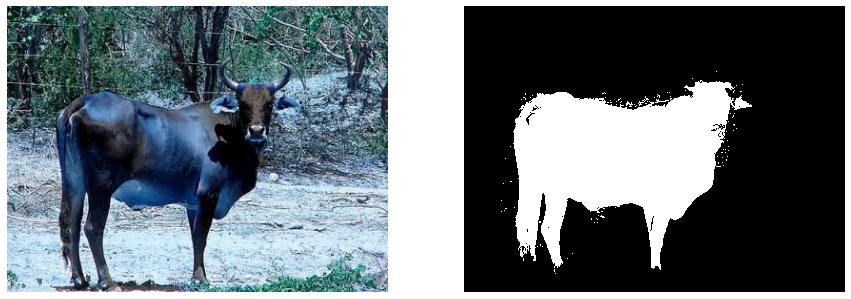

In [7]:
visualize_output('/content/Image1.jpg')

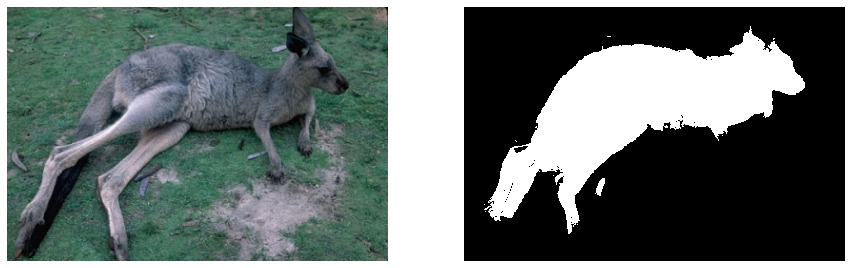

In [8]:
visualize_output('/content/Image2.jpg')

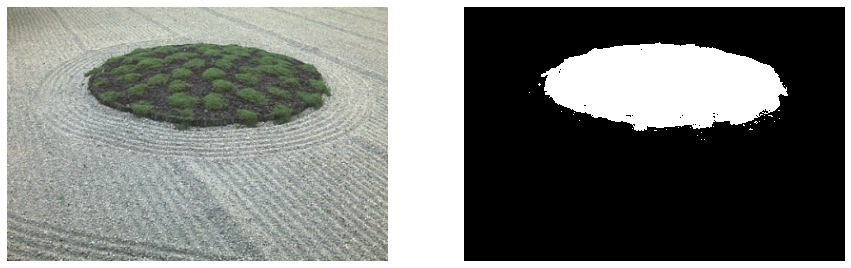

In [9]:
visualize_output('/content/Image3.jpg')

References

1. https://ee.cooper.edu/~keene/assets/rafi_thesis.pdf